In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
import copy

Lets define a function that will help us find the smallest width and height of images in dataset for rescaling.

In [2]:
def smallest_image_sizes(main_folder):

    """
    Finds the smallest width and height among all images in the specified main folder and its subfolders
    and plots histograms of the widths and heights of these images.

    Args:
        main_folder (str): Path to the main directory containing subfolders with images.

    Returns:
        tuple: A tuple containing the smallest width and smallest height found among all images.

    The function performs the following steps:
    1. Iterates through all subfolders in the main folder.
    2. Loads each image with '.png', '.jpg', or '.jpeg' extension in each subfolder using OpenCV.
    3. Keeps track of the smallest width and height encountered.
    4. Stores all widths and heights for plotting.
    5. Plots histograms of the widths and heights.
    6. Returns the smallest width and height as a tuple.
    """

    widths = []
    heights = []

    smallest_width, smallest_height = float('inf'), float('inf')

    for subfolder in os.listdir(main_folder):
        subdir = os.path.join(main_folder, subfolder)

        if os.path.isdir(subdir):

            for filename in os.listdir(subdir):
                file_path = os.path.join(subdir, filename)

                if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Load the image using OpenCV
                    image = cv.imread(file_path)

                    # Ensure the image was loaded successfully
                    if image is not None:
                        # Get the dimensions of the image
                        height, width, _ = image.shape
                        smallest_width = min(smallest_width, width)
                        smallest_height = min(smallest_height, height)
                        widths.append(width)
                        heights.append(height)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].hist(widths, bins=20, color='blue', alpha=0.7)
    axs[0].set_title('Histogram of Image Widths')
    axs[0].set_xlabel('Width')
    axs[0].set_ylabel('Frequency')

    # Plot histogram of heights
    axs[1].hist(heights, bins=20, color='green', alpha=0.7)
    axs[1].set_title('Histogram of Image Heights')
    axs[1].set_xlabel('Height')
    axs[1].set_ylabel('Frequency')

    # Show plots
    plt.tight_layout()
    plt.show()
    
    return int(smallest_width), int(smallest_height)

Now lets make a function for loading the images and splitting them into training and validation set (test set is already separated).

In [3]:
def load_images(main_folder, val_ratio, test_ratio, smallest_width, smallest_height, shuffle = True, random_seed = 42):

    """
    Loads and resizes images from the specified main folder and splits them into training, validation, and test sets.

    Args:
        main_folder (str): Path to the main directory containing subfolders with images.
        val_ratio (float): Proportion of the data to be used for validation (0 <= val_ratio < 1).
        test_ratio (float): Proportion of the data to be used for testing (0 <= test_ratio < 1).
        smallest_width (int): Width to which all images will be resized.
        smallest_height (int): Height to which all images will be resized.
        shuffle (bool, optional): Whether to shuffle the images before splitting. Default is True.
        random_seed (int, optional): Seed for the random number generator used in shuffling. Default is 42.

    Returns:
        tuple: Depending on the provided val_ratio and test_ratio, the function returns:
            - labels (dict): A dictionary mapping label indices to subfolder names.
            - train_images (ndarray): Array of training images.
            - val_images (ndarray, optional): Array of validation images.
            - test_images (ndarray, optional): Array of test images.
            - train_labels (ndarray): Array of training labels.
            - val_labels (ndarray, optional): Array of validation labels.
            - test_labels (ndarray, optional): Array of test labels.

    The function performs the following steps:
    1. Asserts that the validation and test ratios are within valid ranges.
    2. Initializes arrays for storing images and labels.
    3. Iterates through the subfolders in the main folder and processes each image.
    4. Resizes each image to the specified dimensions and converts it from BGR to RGB.
    5. Splits the images into training, validation, and test sets based on the specified ratios.
    6. Returns the images and labels as numpy arrays.
    """

    assert val_ratio < 1  and val_ratio >= 0
    assert test_ratio < 1 and test_ratio >= 0
    assert val_ratio+test_ratio < 1

    random.seed(random_seed)

    train_image_array = []
    train_labels = []
    val_image_array = []
    val_labels = []
    test_image_array = []
    test_labels = []
    labels = {}
    for label, subfolder in enumerate(os.listdir(main_folder)):
        labels[label] = subfolder
        subdir = os.path.join(main_folder, subfolder)
        subfolder_image_array = []
        subfolder_labels = []

        if os.path.isdir(subdir):

            for filename in os.listdir(subdir):
                file_path = os.path.join(subdir, filename)

                if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Load the image using OpenCV
                    image = cv.imread(file_path)
                    image = cv.resize(image, (smallest_width, smallest_height), interpolation=cv.INTER_AREA)

                    # Ensure the image was loaded successfully
                    if image is not None:
                        # Convert BGR to RGB
                        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                        subfolder_image_array.append(image)
                        subfolder_labels.append(label)
            
            n_train = int((1 - val_ratio) * (1 - test_ratio) * len(subfolder_image_array))
            n_val = int(val_ratio * (1 - test_ratio) * len(subfolder_image_array))

            combined = list(zip(subfolder_image_array, subfolder_labels))
            random.shuffle(combined)
            subfolder_image_array, subfolder_labels = zip(*combined)

            for i, image in enumerate(subfolder_image_array):
                if i < n_train:
                    train_image_array.append(image)
                    train_labels.append(subfolder_labels[i])
                elif n_train < i < n_train + n_val:
                    val_image_array.append(image)
                    val_labels.append(subfolder_labels[i])
                else:
                    test_image_array.append(image)
                    test_labels.append(subfolder_labels[i])

    if test_ratio > 0 and val_ratio > 0:
        return labels, np.array(train_image_array), np.array(val_image_array), np.array(test_image_array), np.array(train_labels), np.array(val_labels), np.array(test_labels)
    elif val_ratio > 0:
        return labels, np.array(train_image_array), np.array(val_image_array), np.array(train_labels), np.array(val_labels)
    elif test_ratio > 0:
        return labels, np.array(train_image_array), np.array(test_image_array), np.array(train_labels), np.array(test_labels)
    else:
        return labels, np.array(train_image_array), np.array(train_labels)

Function for one-hot encoding the labels of images.

In [4]:
def one_hot_encode(y, class_dict):
    
    """
    Converts a list of class labels into one-hot encoded vectors.

    Args:
        y (list or ndarray): List or array of class labels to be encoded.
        class_dict (dict): Dictionary mapping class labels to their respective class indices.

    Returns:
        ndarray: A 2D numpy array where each row represents a one-hot encoded vector corresponding to the input class labels.
    """

    one_hot_encoded = []
    
    for num in y:
        one_hot_vector = np.zeros(len(class_dict))
        
        index = list(class_dict.values()).index(class_dict[num])
        
        one_hot_vector[index] = 1
        one_hot_encoded.append(one_hot_vector)
    
    one_hot_encoded = np.array(one_hot_encoded)
    return one_hot_encoded

Okay now lest find the smallest width and height in dataset, load and rescale the images.

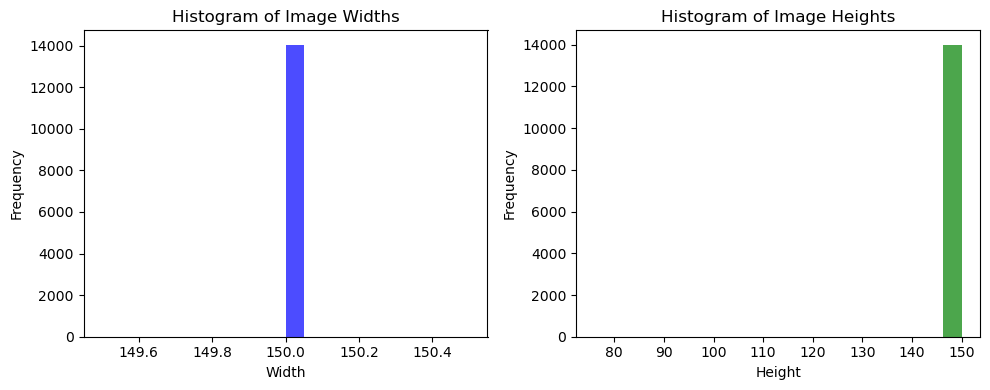

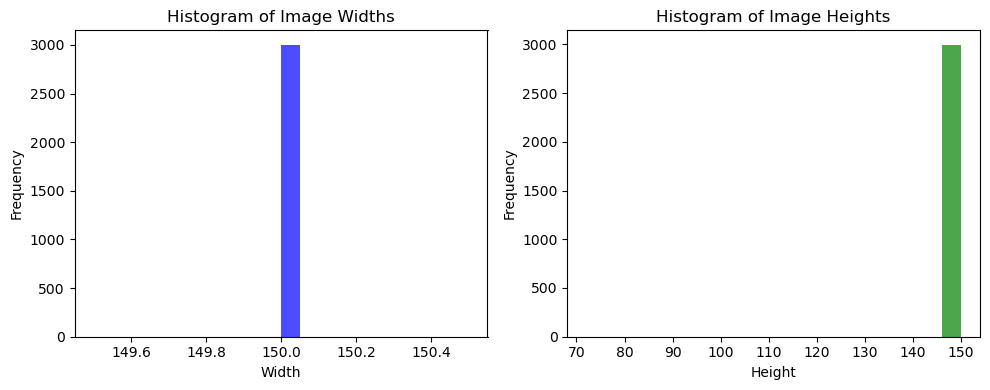

150 72


In [5]:
train_folder_path = 'Classification_data/train'
test_folder_path = 'Classification_data/test'

smallest_width1, smallest_height1 = smallest_image_sizes(train_folder_path)
smallest_width2, smallest_height2 = smallest_image_sizes(test_folder_path)

smallest_width = min(smallest_width1,smallest_width2)
smallest_height = min(smallest_height1,smallest_height2)
print(smallest_width, smallest_height)

From the histograms of widths and heights in training and test set images we can see that they are already the same size.

In [6]:
labels, X_train, y_train = load_images(train_folder_path, 0, 0, smallest_width, smallest_height)
_, X_test, y_test        = load_images(test_folder_path, 0, 0, smallest_width, smallest_height)


# Normalizing the pixels values
X_train, X_test = X_train / 255.0, X_test / 255.0

In [7]:
X_train.shape

(14034, 72, 150, 3)

Lets check if images were loaded correctly.

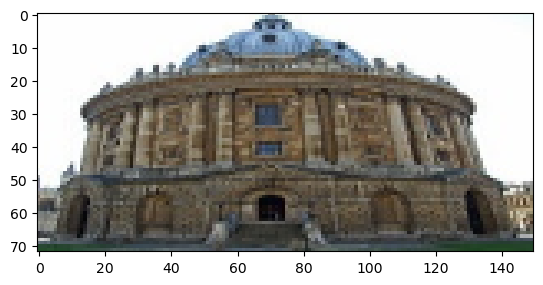

In [8]:
plt.imshow(X_train[500])

In [9]:
print(labels[y_train[500]])

buildings


Here we will create a function for extraction of Histogram of Gradients (HOG) from the images. This will allow us to train some classical machine learning model for the classification task.

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print('cuda')
else:
    print('no cuda')

cuda


In [11]:
labels, X_train, X_val, y_train, y_val = load_images(train_folder_path, 0.2, 0, smallest_width, smallest_height)
_, X_test, y_test                     = load_images(test_folder_path, 0, 0, smallest_width, smallest_height)

X_train, X_valid, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

y_train = one_hot_encode(y_train,labels)
y_val = one_hot_encode(y_val,labels)
y_test  = one_hot_encode(y_test,labels)

Lets convert our data to torch tensors and create data loaders. We will also initialize our CNN, optimizer will be Adam and loss function - cross entropy.

In [12]:
X_train_tensor = torch.tensor(X_train.transpose((0, 3, 1, 2)), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.transpose((0, 3, 1, 2)), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.transpose((0, 3, 1, 2)), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [13]:
X_train_tensor.shape

torch.Size([11224, 3, 72, 150])

## Finetuned CNN

We will use SqueezeNet - it is lightweight network with relatively small number of parameters and its flexible in case of input size.

In [15]:
import torchvision.models as models

squeeze = models.squeezenet1_0(weights='SqueezeNet1_0_Weights.DEFAULT')#.to(device)

In [15]:
num_classes = len(labels)  

# Modify final layer
#num_features = squeeze.fc.in_features
#squeeze.fc = nn.Linear(num_features, num_classes)

Lets take a look at its architecture.

In [16]:
squeeze.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

We choose cross entropy as our loss and Stochastic Gradient Descent as our optimizer.

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(squeeze.parameters(), lr=0.001, momentum=0.9)

Now lets train the model.

In [20]:
train_res_history = []
val_res_history = []

best_val_accuracy = 0.0  
best_model_params = None  

num_epochs = 20

for epoch in range(num_epochs):
    start_time = time.time()
    
    squeeze.train()
    total_loss = 0.0
    
    # Training loop
    for inputs, one_hot_labels in train_loader:
        labels = torch.argmax(one_hot_labels, dim=1)  
        optimizer.zero_grad()
        
        outputs = squeeze(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss
    avg_train_loss = total_loss / len(train_loader.dataset)
    train_res_history.append(avg_train_loss)

    # Validation loop
    squeeze.eval()
    total_correct = 0
    total_val_loss = 0.0

    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            labels = torch.argmax(one_hot_labels, dim=1)  # Convert one-hot encoded labels to class indices
            
            outputs = squeeze(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total_correct += (predicted == labels).sum().item()

            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item() * inputs.size(0)
    
    # Calculate validation accuracy
    val_accuracy = total_correct / len(val_loader.dataset)
    val_res_history.append(val_accuracy)

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    
    # Save best model parameters
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_res_params = squeeze.state_dict()
        torch.save(best_res_params, 'best_model.pth')

    end_time = time.time()
    epoch_time = end_time - start_time
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%, Time: {epoch_time:.2f}s")

Epoch 1/20, Loss: 0.7758, Validation Accuracy: 47.78%, Time: 62.13s
Epoch 2/20, Loss: 0.5085, Validation Accuracy: 29.09%, Time: 61.73s
Epoch 3/20, Loss: 0.4284, Validation Accuracy: 44.89%, Time: 61.49s
Epoch 4/20, Loss: 0.3771, Validation Accuracy: 50.21%, Time: 61.60s
Epoch 5/20, Loss: 0.3489, Validation Accuracy: 43.71%, Time: 61.53s
Epoch 6/20, Loss: 0.3214, Validation Accuracy: 43.10%, Time: 61.61s
Epoch 7/20, Loss: 0.2984, Validation Accuracy: 48.68%, Time: 61.56s
Epoch 8/20, Loss: 0.3008, Validation Accuracy: 49.82%, Time: 61.52s
Epoch 9/20, Loss: 0.2602, Validation Accuracy: 46.46%, Time: 61.67s
Epoch 10/20, Loss: 0.2585, Validation Accuracy: 58.22%, Time: 62.87s
Epoch 11/20, Loss: 0.2426, Validation Accuracy: 51.89%, Time: 924.56s
Epoch 12/20, Loss: 0.2252, Validation Accuracy: 49.46%, Time: 93.14s
Epoch 13/20, Loss: 0.2091, Validation Accuracy: 42.82%, Time: 91.17s
Epoch 14/20, Loss: 0.2027, Validation Accuracy: 47.03%, Time: 91.21s
Epoch 15/20, Loss: 0.1837, Validation Accu

In [ ]:
state_dict = torch.load('best_model.pth')
if squeeze is None:   
    squeeze = models.squeezenet1_0(weights='SqueezeNet1_0_Weights.DEFAULT')  # .to(device) if using GPU
squeeze.load_state_dict(state_dict)

squeeze.to(torch.device('cpu'))

Time for testing:

In [17]:
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

squeeze.eval()
total_correct = 0
times = []

with torch.no_grad():
    start_time = time.time()

    for batch in test_loader:

        inputs, one_hot_labels = batch  # Assuming labels are one-hot encoded
        labels = torch.argmax(one_hot_labels, dim=1)  # Convert one-hot encoded labels to class indices
        
        start_batch_time = time.time()
        outputs = squeeze(inputs)
        end_batch_time = time.time()
        times.append(end_batch_time-start_batch_time)
        _, predicted = torch.max(outputs, 1)
        
        total_correct += (predicted == labels).sum().item()

end_time = time.time()
test_accuracy = total_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Total inference time: {(end_time-start_time):.5f}s, Average single inference time: {np.mean(times):.5f}s")

Test Accuracy: 85.67%
Total inference time: 6.88513s, Average single inference time: 0.14304s


Lets make a copy of our model.

In [18]:
quant_squeeze = copy.deepcopy(squeeze.eval())

Now we can quantize it.

In [ ]:
quant_squeeze.qconfig=torch.quantization.get_default_qat_qconfig('fbgemm')

# insert observers
torch.quantization.prepare(quant_squeeze, inplace=True)#, inplace=True)

# Calibrate using a calibration dataset
calibration_dataset = TensorDataset(X_val_tensor, y_val_tensor)
calibration_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for inputs, _ in calibration_loader:
        quant_squeeze(inputs)

# convert to quantized version
torch.quantization.convert(quant_squeeze, inplace=True)
quant_squeeze.to('cpu')

Now we can test our quantized model in the same way:

In [21]:
quant_squeeze.eval()
total_correct = 0
times = []

with torch.no_grad():
    start_time = time.time()

    for batch in test_loader:

        inputs, one_hot_labels = batch  # Assuming labels are one-hot encoded

        inputs_q = torch.quantize_per_tensor(inputs, scale=1.0/255, zero_point=0, dtype=torch.quint8)
        labels = torch.argmax(one_hot_labels, dim=1).to(dtype=torch.int8)#dtype=torch.int64)  

        #labels = torch.argmax(one_hot_labels, dim=1).to(dtype = torch.qint8)  # Convert one-hot encoded labels to class indices
        
        start_batch_time = time.time()
        outputs = quant_squeeze(inputs_q)
        end_batch_time = time.time()
        times.append(end_batch_time-start_batch_time)
        _, predicted = torch.max(outputs, 1)
        
        total_correct += (predicted == labels).sum().item()

end_time = time.time()
test_accuracy = total_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Total inference time: {(end_time-start_time):.5f}s, Average single inference time: {np.mean(times):.5f}s")

Test Accuracy: 85.63%
Total inference time: 3.39230s, Average single inference time: 0.06797s


Standard model:
<br>
<br>
Test Accuracy: 85.67%
Total inference time: 6.88513s, Average single inference time: 0.14304
<br>
<br>
Quantized model:
<br>
<br>
Test Accuracy: 85.63%
Total inference time: 3.39230s, Average single inference time: 0.06797s

We can see that, while keeping almost identical accuracy on the test set, quantized model managed to have total inference time over 2 times shorter, same with an average prediction on a single batch. It is a big improvement that didn't worsen performance of our model.